# LoL Competitive Match Prediction
1. [Introduction](#introduction)
2. [Exploratory Data Analysis](#exploring-the-data)
3. [Pre-processing](#pre-process)
    1. [Feature Engineering](#feature-engineering)
4. [Modeling](#models)
    1. [Train Test Split](#train-test)
    2. [Logistic Regression](#log-model)
        1. [Performance Evaluation](#log-model-performance)
    3. [Random Forest](#random-forest-modeel)
        1. [Performance Evaluation](#random-forest-performance)
    4. [Neural Model](#neural-model)
        1. [Performance Evaluation](#neural-model-performance)
5. [Results](#results)
6. [Impact](#impact)
# 1. Introduction <a name="introduction"></a>
Members: Kevin Alvarez, David Jimenez, Sheriff Sanni, Sufian Ilyas


In this project, we will develop a model using historical data from the esports leagues of the Multiplayer Online Battle Arena, League of Legends, to forecast the outcome of future matches between different teams. This model may be useful to those interested in predicting the results of upcoming matches within these leagues, or perhaps those interested in understanding important attributes which change over time, or their variance in contribution to a teams results. For instance, this can be team coaches/leads, players trying to improve, viewers who are curious about future or unscheduled match outcomes (including international matches), and LoL betters. By using this model, coaches and players can develop strategies and training regiments which reflect those of the teams which the model is favorable in terms of winning in order to better their team's play or their own play respectively. In addition, coaches and players can use this model to see how they fair up against international teams which are too far geographically to conveniently schedule a scrimmage or match with. This includes aspects such as winning teams team compositions, bans, and objective priority.

Let's start off by loading in match data of League of Legends competitive matches that took place in the year of 2020. https://www.kaggle.com/fernandorubiogarcia/2020-league-of-legends-competitive-games

Since this model is intended for people who already have background knowledge on the game such as players, fans and people in the Esports scene, it is not necessary to explain vocabulary relating to the game. However, to better understand certain terms and concepts in league of legends, you can refer to the wiki here: https://leagueoflegends.fandom.com/wiki/League_of_Legends_Wiki

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import utils
from sklearn.linear_model import LogisticRegression

data_df = pd.read_csv("league_match_data.csv", delimiter=';')
data_df.head()

,gameId,league,split,playoffs,date,game,patch,gamelength,t1_playerid,t1_ban1,...,t2p5_monsterkills,t2p5_monsterkillsownjungle,t2p5_monsterkillsenemyjungle,t2p5_cspm,t2p5_goldat10,t2p5pat10,t2p5_csat10,t2p5_goldat15,t2p5pat15,t2p5_csat15
0,1241318,KeSPA,NaN,0,03/01/2020 7:33,1,9.24,2220,SANDBOX Gaming,LeBlanc,...,27.0,18.0,0.0,8.2162,2845.0,4432.0,65.0,4723.0,7202.0,118.0
1,1241322,KeSPA,NaN,0,03/01/2020 9:00,2,9.24,2227,T1,Syndra,...,42.0,15.0,5.0,8.5406,3657.0,5135.0,93.0,6627.0,8784.0,162.0
2,1241324,KeSPA,NaN,0,03/01/2020 10:05,3,9.24,1711,T1,LeBlanc,...,8.0,1.0,0.0,8.2759,3282.0,4851.0,90.0,5252.0,7933.0,150.0
3,1241328,KeSPA,NaN,0,03/01/2020 10:57,4,9.24,1999,T1,Rumble,...,16.0,4.0,9.0,9.4247,3351.0,4671.0,92.0,5190.0,7374.0,144.0
4,1241386,KeSPA,NaN,0,04/01/2020 5:33,1,9.24,1812,DRX,Qiyana,...,27.0,12.0,4.0,8.9404,3587.0,4809.0,88.0,5114.0,7078.0,134.0


# 2. Exploratory Data Analysis  <a name="exploring-the-data"></a>
We can immediately see that this data has 408 different features. Most of these features include team or player specific things from the match. We'll have to explore to see what this includes.

In [ ]:
print(data_df.columns)

Index(['gameId', 'league', 'split', 'playoffs', 'date', 'game', 'patch',
       'gamelength', 't1_playerid', 't1_ban1',
       ...
       't2p5_monsterkills', 't2p5_monsterkillsownjungle',
       't2p5_monsterkillsenemyjungle', 't2p5_cspm', 't2p5_goldat10',
       't2p5pat10', 't2p5_csat10', 't2p5_goldat15', 't2p5pat15',
       't2p5_csat15'],
      dtype='object', length=408)


Firstly, reviewing player independent data as potential features for our model may be useful, as our predictions are based on comparing the strengths of teams rather than individual players. Perhaps later we may develop additional team features by using the combined values of individual player features later on.



In [ ]:
data_df[data_df.isnull().any(axis=1)]

,gameId,league,split,playoffs,date,game,patch,gamelength,t1_playerid,t1_ban1,...,t2p5_monsterkills,t2p5_monsterkillsownjungle,t2p5_monsterkillsenemyjungle,t2p5_cspm,t2p5_goldat10,t2p5pat10,t2p5_csat10,t2p5_goldat15,t2p5pat15,t2p5_csat15
0,1241318,KeSPA,NaN,0,03/01/2020 7:33,1,9.24,2220,SANDBOX Gaming,LeBlanc,...,27.0,18.0,0.0,8.2162,2845.0,4432.0,65.0,4723.0,7202.0,118.0
1,1241322,KeSPA,NaN,0,03/01/2020 9:00,2,9.24,2227,T1,Syndra,...,42.0,15.0,5.0,8.5406,3657.0,5135.0,93.0,6627.0,8784.0,162.0
2,1241324,KeSPA,NaN,0,03/01/2020 10:05,3,9.24,1711,T1,LeBlanc,...,8.0,1.0,0.0,8.2759,3282.0,4851.0,90.0,5252.0,7933.0,150.0
3,1241328,KeSPA,NaN,0,03/01/2020 10:57,4,9.24,1999,T1,Rumble,...,16.0,4.0,9.0,9.4247,3351.0,4671.0,92.0,5190.0,7374.0,144.0
4,1241386,KeSPA,NaN,0,04/01/2020 5:33,1,9.24,1812,DRX,Qiyana,...,27.0,12.0,4.0,8.9404,3587.0,4809.0,88.0,5114.0,7078.0,134.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5144,1310259,EM,NaN,0,18/08/2020 20:25,1,10.16,2075,Racoon,Caitlyn,...,12.0,8.0,4.0,6.9976,3613.0,4564.0,83.0,5159.0,6917.0,127.0
5145,1310260,EM,NaN,0,18/08/2020 20:27,1,10.16,2095,SINNERS Esports,Shen,...,8.0,0.0,4.0,4.4105,2509.0,3346.0,49.0,4212.0,4791.0,72.0
5146,1310262,EM,NaN,0,18/08/2020 20:53,1,10.16,2879,Team GamerLegion,Nidalee,...,10.0,10.0,0.0,7.0441,2995.0,4173.0,54.0,4536.0,6535.0,93.0
5147,1320317,EM,NaN,0,18/08/2020 20:56,1,10.16,1874,G2 Arctic,Cho'Gath,...,1.0,1.0,0.0,6.1473,3177.0,4291.0,57.0,5139.0,7260.0,109.0


There seems to be a bit of missing data which we'll have to filter out. Numerical columns with missing values we will likely replace with the mean of the column, while columns containing names such as the "bans" columns, we will create values indicating the absence such as "no ban". Also, the dataset has too many columns, so we will have to trim down which features are of upmost importance or combine features. One thing noticeable here is that the data includes data from international leagues. This is important, as our model could be especially useful in predicting the outcomes of international matchups, which cannot be done very conveniently otherwise.

Columns with string values such as champion and team names would also need to be transformed through one hot encoding or other methods before being fed into the model.

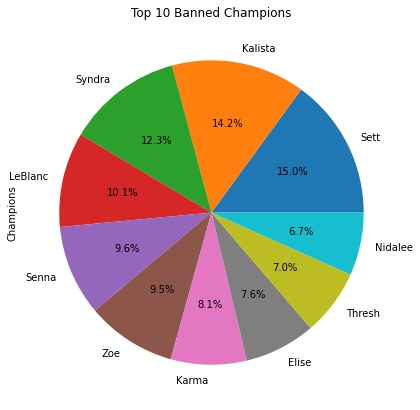

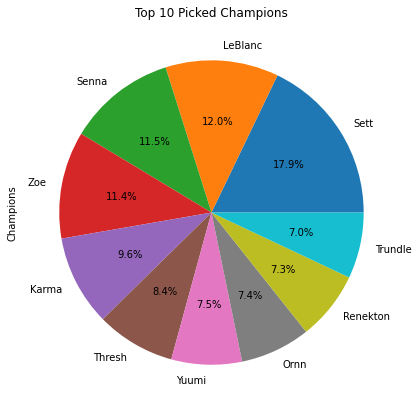

In [ ]:
utils.piecharts(data_df)

Taking into consideration highly contested champions may be important in training our model. The most picked and most banned champions indicate contested picks which teams most likely feel synergize with or counter their own team composition or playstyle, and also indicate the champion's overall strength in general compared to other champions. By looking at each team's composition before the match, our model may be able to examine the contested champions each team acquired in the draft, and influence its prediction based on which team drafted better.

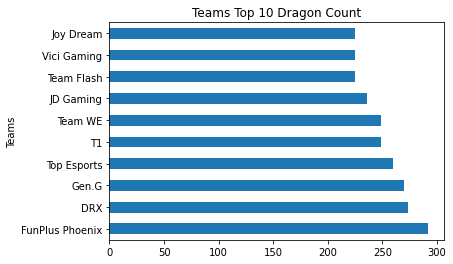

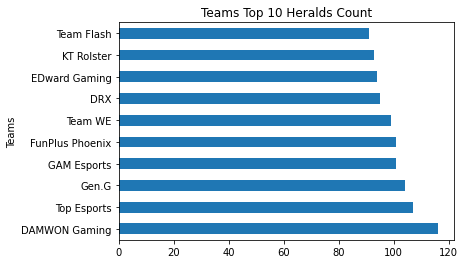

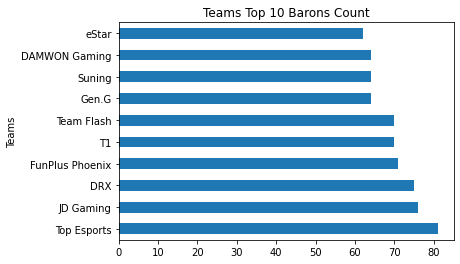

In [ ]:
utils.bargraphs(data_df)

In the case that all teams play the same amount of games, we can use the sums of a teams total objectives to see how they fair up against other teams total objectives. We can conclude from this data how the these objectives correlate with top teams, how top teams prioritize certain objectives, and as data to predict a matchup by taking the difference in total objectives between the two teams.



One important thing to look at is the wins and losses of different teams. This should give us an idea of which teams have been winning the most in 2020.

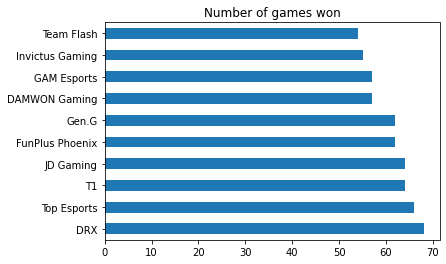

In [ ]:
utils.bargraphs2(data_df)

However, we should also take into account the percentage of wins/losses. It is just possible that some teams play more matches than others.

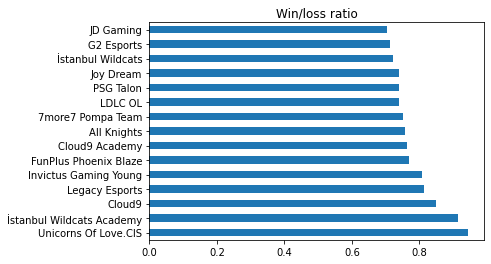

In [ ]:
utils.bargraphs3(data_df)

In looking at the ratio of wins/losses per team, we see that see some teams have a high win/loss percentage. However, some of these teams don't line up with what we saw in the bar graph above. This is probably due to not playing as many matches. However, this can become a feature on it's own where we include the current win/loss calculated from previous matches while making sure it doesn't include any future data.


Our primary concern with this model is comparing the strength of teams. In regards to this the primary critical attribute is winning. Thus, this will likely be our main target variable for this model. Since results are held in t1_result and t2_result which are just the inverse of each other, we'll have to choose to focus on one of these. However, in combining the results data we can see which teams have won the most and about how many games.

In this part of the project, we will continue to build several models to predict the outcome of future games using historical data. The audience is anyone who is part of the league, this may include the players, couches and the viewers. This hasn't changed from the previous check-in.

# 3. Pre-processing <a name="pre-process"></a>

Since we saw earlier that we have some missing values. We'll have to update them or remove them. For numerical values we decided to use the mean and for labels we'll be filling Nan values with None. This way it doesn't run into any issues when we encode them. We didn't have too many Nan values to begin with, most of the ones we did have involved the ban columns which we could fill with None.

In [ ]:
data_df[['t1_ban1', 't1_ban2', 't1_ban3', 't1_ban4', 't1_ban5', 't2_ban1', 't2_ban2', 't2_ban3', 't2_ban4', 't2_ban5']] = data_df[['t1_ban1', 't1_ban2', 't1_ban3', 't1_ban4', 't1_ban5', 't2_ban1', 't2_ban2', 't2_ban3', 't2_ban4', 't2_ban5']].fillna('None')
data_df = data_df.dropna()
data_df[data_df.isnull().any(axis=1)]

,gameId,league,split,playoffs,date,game,patch,gamelength,t1_playerid,t1_ban1,...,t2p5_monsterkills,t2p5_monsterkillsownjungle,t2p5_monsterkillsenemyjungle,t2p5_cspm,t2p5_goldat10,t2p5pat10,t2p5_csat10,t2p5_goldat15,t2p5pat15,t2p5_csat15


One thing we'll start off doing is one-hot encoding our categorical features. To do this first we'll make the strings lowercase, trim them and replace spaces with '_' to make sure similar strings are the same. This is important as we don't want to accidentally create different encodings for the same teams, players, or champions.

Afterwards we'll use pd.get_dummies() to generate our one-hot encodings and merge it with our main dataframe.

In [ ]:
dum_df = utils.oneHotEncodeData(data_df)
data_df = data_df.merge(dum_df,how='left')

Let's start by intializing a list of features which we want to keep. The first features we'll add are our newly generated one-hot encodings for teams, players, and champions. 

Since we're trying to make predictions prior to the match starting, we have to make sure we're not passing in any data from during or after the match.

In [ ]:
categorical_columns = ['t1_playerid_','t2_playerid_','t1p1_player_','t1p2_player_','t1p3_player_','t1p4_player',
    't1p5_player_','t2p1_player_','t2p2_player_','t2p3_player_','t2p4_player_','t2p5_player_',
    't1p1_champion_','t1p2_champion_','t1p3_champion_','t1p4_champion_',
    't1p5_champion_','t2p1_champion_','t2p2_champion_','t2p3_champion_','t2p4_champion_','t2p5_champion_',
    't1_ban1_','t1_ban2_','t1_ban3_','t1_ban4_','t1_ban5_','t2_ban1_','t2_ban2_','t2_ban3_','t2_ban4_','t2_ban5_',]
feature_names = []
for item in dum_df.columns:
    for cat in categorical_columns:
        if cat in item:
            feature_names.append(item)

### 3.1 Feature Engineering <a href="feature-engineering"></a>

Since many of the columns in our dataset are from during/after the matches. We won't be able to keep them, however, we can use them to generate lagged features.

### 3.1.1 Winrate Feature
So far our features are mainly categorical. We'll want to generate some additional features. A possible feature is to keep track of a teams wins and losses.         However, we also have to keep in mind that we don't want to time-skip with this data so we'll only be adding up a teams wins and losses up to that match.

In [ ]:
data_df = utils.addWinRate(data_df,dum_df)

feature_names.append('t1_games_won_so_far')
feature_names.append('t1_games_played_so_far')
feature_names.append('t2_games_won_so_far')
feature_names.append('t2_games_played_so_far')
feature_names.append('t1_winrate')
feature_names.append('t2_winrate')

print("Let's see how this might look for one team")
data_df[data_df['t1_playerid_invictus_gaming'] == 1][['t1_result','t1_games_won_so_far','t1_games_played_so_far','t1_winrate']]

Let's see how this might look for one team


,t1_result,t1_games_won_so_far,t1_games_played_so_far,t1_winrate
0,1,0,0.0,0.000000
2,1,1,1.0,1.000000
10,1,2,2.0,1.000000
804,1,3,3.0,1.000000
912,1,4,4.0,1.000000
914,1,5,5.0,1.000000
962,1,6,6.0,1.000000
965,1,7,7.0,1.000000
1012,0,8,8.0,1.000000
1013,0,8,9.0,0.888889


After running that code, we can verify that our data is not time skipping by looking at the win and losses colums for one team. Going through the data for invictus_gaming we can see that the values are not time-skipping and the math works out correctly.

### 3.1.2 KDA Feature
Player ability is crucial in predicting who might win a game of league of legends, better players win more games. KDA is a statistic commonly used to measure the how good a player is based on their past games. KDA stands for Kills, deaths, and assists. it is calculated adding the total number of a player's kills and assists, then dividing that by their total number of deaths.

This feature will be lagged so that at the the time of prediction, there is only information from the previous games.

In [ ]:
#cummulative sum of each player's kills, deaths and assists
data_df = utils.cummsum('t1p1_kills_sum','t1p1_player','t1p1_kills',data_df)
data_df = utils.cummsum('t1p2_kills_sum','t1p2_player','t1p2_kills',data_df)
data_df = utils.cummsum('t1p3_kills_sum','t1p3_player','t1p3_kills',data_df)
data_df = utils.cummsum('t1p4_kills_sum','t1p4_player','t1p4_kills',data_df)
data_df = utils.cummsum('t1p5_kills_sum','t1p5_player','t1p5_kills',data_df)

data_df = utils.cummsum('t2p1_kills_sum','t2p1_player','t2p1_kills',data_df)
data_df = utils.cummsum('t2p2_kills_sum','t2p2_player','t2p2_kills',data_df)
data_df = utils.cummsum('t2p3_kills_sum','t2p3_player','t2p3_kills',data_df)
data_df = utils.cummsum('t2p4_kills_sum','t2p4_player','t2p4_kills',data_df)
data_df = utils.cummsum('t2p5_kills_sum','t2p5_player','t2p5_kills',data_df)

data_df = utils.cummsum('t1p1_assists_sum','t1p1_player','t1p1_assists',data_df)
data_df = utils.cummsum('t1p2_assists_sum','t1p2_player','t1p2_assists',data_df)
data_df = utils.cummsum('t1p3_assists_sum','t1p3_player','t1p3_assists',data_df)
data_df = utils.cummsum('t1p4_assists_sum','t1p4_player','t1p4_assists',data_df)
data_df = utils.cummsum('t1p5_assists_sum','t1p5_player','t1p5_assists',data_df)

data_df = utils.cummsum('t2p1_assists_sum','t1p1_player','t2p1_assists',data_df)
data_df = utils.cummsum('t2p2_assists_sum','t1p2_player','t2p2_assists',data_df)
data_df = utils.cummsum('t2p3_assists_sum','t1p3_player','t2p3_assists',data_df)
data_df = utils.cummsum('t2p4_assists_sum','t1p4_player','t2p4_assists',data_df)
data_df = utils.cummsum('t2p5_assists_sum','t1p5_player','t2p5_assists',data_df)

data_df = utils.cummsum('t1p1_deaths_sum','t1p1_player','t1p1_deaths',data_df)
data_df = utils.cummsum('t1p2_deaths_sum','t1p2_player','t1p2_deaths',data_df)
data_df = utils.cummsum('t1p3_deaths_sum','t1p3_player','t1p3_deaths',data_df)
data_df = utils.cummsum('t1p4_deaths_sum','t1p4_player','t1p4_deaths',data_df)
data_df = utils.cummsum('t1p5_deaths_sum','t1p5_player','t1p5_deaths',data_df)

data_df = utils.cummsum('t2p1_deaths_sum','t2p1_player','t2p1_deaths',data_df)
data_df = utils.cummsum('t2p2_deaths_sum','t2p2_player','t2p2_deaths',data_df)
data_df = utils.cummsum('t2p3_deaths_sum','t2p3_player','t2p3_deaths',data_df)
data_df = utils.cummsum('t2p4_deaths_sum','t2p4_player','t2p4_deaths',data_df)
data_df = utils.cummsum('t2p5_deaths_sum','t2p5_player','t2p5_deaths',data_df)

#creating new columns for player deaths with 0's replaced with 1's to calculate KDA without dividing by 0
data_df = utils.rep('t1p1_d','t1p1_deaths_sum', data_df)
data_df = utils.rep('t1p2_d','t1p2_deaths_sum', data_df)
data_df = utils.rep('t1p3_d','t1p3_deaths_sum', data_df)
data_df = utils.rep('t1p4_d','t1p4_deaths_sum', data_df)
data_df = utils.rep('t1p5_d','t1p5_deaths_sum', data_df)

data_df = utils.rep('t2p1_d','t2p1_deaths_sum', data_df)
data_df = utils.rep('t2p2_d','t2p2_deaths_sum', data_df)
data_df = utils.rep('t2p3_d','t2p3_deaths_sum', data_df)
data_df = utils.rep('t2p4_d','t2p4_deaths_sum', data_df)
data_df = utils.rep('t2p5_d','t2p5_deaths_sum', data_df)

#calculating player kda
data_df = utils.kda('t1p1_kda', 't1p1_kills_sum', 't1p1_assists_sum', 't1p1_d', data_df)
data_df = utils.kda('t1p2_kda', 't1p2_kills_sum', 't1p2_assists_sum', 't1p2_d', data_df)
data_df = utils.kda('t1p3_kda', 't1p3_kills_sum', 't1p3_assists_sum', 't1p3_d', data_df)
data_df = utils.kda('t1p4_kda', 't1p4_kills_sum', 't1p4_assists_sum', 't1p4_d', data_df)
data_df = utils.kda('t1p5_kda', 't1p5_kills_sum', 't1p5_assists_sum', 't1p5_d', data_df)

data_df = utils.kda('t2p1_kda', 't2p1_kills_sum', 't2p1_assists_sum', 't2p1_d', data_df)
data_df = utils.kda('t2p2_kda', 't2p2_kills_sum', 't2p2_assists_sum', 't2p2_d', data_df)
data_df = utils.kda('t2p3_kda', 't2p3_kills_sum', 't2p3_assists_sum', 't2p3_d', data_df)
data_df = utils.kda('t2p4_kda', 't2p4_kills_sum', 't2p4_assists_sum', 't2p4_d', data_df)
data_df = utils.kda('t2p5_kda', 't2p5_kills_sum', 't2p5_assists_sum', 't2p5_d', data_df)

#looking at a specific player to verify
data_df[data_df['t1p5_player'] == 'huni'][['t1p5_kills','t1p5_kills_sum','t1p5_assists','t1p5_assists_sum','t1p5_deaths','t1p5_deaths_sum','t1p5_deaths','t1p5_kda']]


,t1p5_kills,t1p5_kills_sum,t1p5_assists,t1p5_assists_sum,t1p5_deaths,t1p5_deaths_sum,t1p5_deaths,t1p5_kda
57,1,0.0,1,0.0,0,0.0,0,0.00
109,0,1.0,7,1.0,2,0.0,2,2.00
240,1,1.0,1,8.0,4,2.0,4,4.50
358,0,2.0,3,9.0,1,6.0,1,1.83
456,5,2.0,9,12.0,1,7.0,1,2.00
627,0,7.0,2,21.0,4,8.0,4,3.50
983,2,7.0,10,23.0,4,12.0,4,2.50
1174,2,9.0,5,33.0,0,16.0,0,2.62
1193,2,11.0,9,38.0,3,16.0,3,3.06
1911,7,13.0,10,47.0,5,19.0,5,3.16


In [ ]:
#adding the new features to the model
kda_features = ['t1p1_kda','t1p2_kda','t1p3_kda','t1p4_kda','t1p5_kda','t2p1_kda','t2p2_kda','t2p3_kda','t2p4_kda','t2p5_kda','t1p1_kills_sum','t1p2_kills_sum','t1p3_kills_sum','t1p4_kills_sum','t1p5_kills_sum','t2p1_kills_sum','t2p2_kills_sum','t2p3_kills_sum','t2p4_kills_sum','t2p5_kills_sum','t1p1_deaths_sum','t1p2_deaths_sum','t1p3_deaths_sum','t1p4_deaths_sum','t1p5_deaths_sum',
't2p1_deaths_sum','t2p2_deaths_sum','t2p3_deaths_sum','t2p4_deaths_sum','t2p5_deaths_sum']
for item in kda_features:
    feature_names.append(item)


### 3.1.3 Average Barons per game 

The [Baron Nashor](https://leagueoflegends.fandom.com/wiki/Baron_Nashor_(League_of_Legends)) is arguably the most important objective in the game because it grants a [buff](https://leagueoflegends.fandom.com/wiki/Buff) and gold to the members of the team that is able to kill the baron. it is a highly contested objective so requires both teams to cleverly plan and meneuver ways to secure it over the opponent. Teams that are able to consistently secure the baron are more likely to win their games.

In [ ]:
baron_features = ['t1_avg_baron','t2_avg_baron']
for item in baron_features:
    feature_names.append(item)

data_df = utils.rolling_average(data_df,'t1_baron_count', 't1_barons', 't1_avg_baron', 't2_baron_count', 't2_barons', 't2_avg_baron')
data_df[data_df['t1_playerid'] == 'invictus_gaming'][['t1_avg_baron', 't1_barons']]

,t1_avg_baron,t1_barons
0,0.00,1
2,1.00,1
10,1.00,1
804,1.00,1
912,1.00,1
914,1.00,1
962,1.00,0
965,0.86,1
1012,0.88,0
1013,0.78,0


### 3.1.4 Elemental Drakes Feature

 The elemental drakes are objectives that grant the team that is able to kill it a buff depending of which element the drake is. The buff persists for the entirety of the match and it is significant enough to increase the chances of winning the game, especially when a team is able to capture multiple of this objective in one game

In [ ]:
dragon_features = ['t1_avg_dragon','t2_avg_dragon']
for item in dragon_features:
   feature_names.append(item)

data_df = utils.rolling_average(data_df,'t1_dragon_count', 't1_elementaldrakes', 't1_avg_dragon', 't2_dragon_count', 't2_elementaldrakes', 't2_avg_dragon')
data_df[data_df['t1_playerid'] == 'invictus_gaming'][['t1_avg_dragon', 't2_avg_dragon']]

,t1_avg_dragon,t2_avg_dragon
0,0.00,0.00
2,1.00,4.00
10,1.50,0.00
804,1.33,0.00
912,2.00,2.50
914,2.20,2.20
962,2.00,2.00
965,2.14,2.11
1012,2.25,3.29
1013,2.11,3.38


### 3.1.5 Elder Dragon Feature
The [Elder dragon](https://leagueoflegends.fandom.com/wiki/Elder_Dragon) is an objective that appears late into the game that grants a very powerfull damage increase to the team that secures it. Although this objective isnt seen in most games because most games end before it appears, a team that is able to obtain this buff has significantly higher chance of winning the game

In [ ]:
elders_features = ['t1_avg_elders','t2_avg_elders']
for item in elders_features:
    feature_names.append(item)

data_df = utils.rolling_average(data_df,'t1_elders_count', 't1_elders', 't1_avg_elders', 't2_elders_count', 't2_elders', 't2_avg_elders')

### 3.1.6 Rift Herald Feature
The [Rift Herald](https://leagueoflegends.fandom.com/wiki/Rift_Herald_(League_of_Legends)) is an early game objective that when secured, can be used to take down one of the opposing team's [turrets](https://leagueoflegends.fandom.com/wiki/Turret). Destroying turrets grant gold and the bigger the gold differnce a team has over their opponent, the more likely they come out victorious in a teamfight.

In [ ]:
heralds_features = ['t1_avg_heralds','t2_avg_heralds']
for item in heralds_features:
    feature_names.append(item)

data_df = utils.rolling_average(data_df,'t1_heralds_count', 't1_heralds', 't1_avg_heralds', 't2_heralds_count', 't2_heralds', 't2_avg_heralds')

The final features we'll add are playoffs and game. Since this column is pre-match it might be useful to keep. The playoffs column is a boolean that lets us know if this match was done during a playoff a tournament. This was kept since a team playing in playoff matches might've performed better than a team that isn't in the playoffs. The game column lets us know what game number from a match it is. For instance, game number 2 in a best of 3 match.

In [ ]:
additional_features = ['playoffs', 'game']
for item in additional_features:
    feature_names.append(item)

One last thing to do is to standard scale some of our numerical features. While the amount of kills, deaths, and assists are important, they can cause a bias in our models since some teams might've not played as many games as others.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numerical_feature_columns = []
for item in data_df.columns:
    if 'kills_sum' in item or 'deaths_sum' in item or 'assists_sum' in item:
        numerical_feature_columns.append(item)

data_df.loc[:, numerical_feature_columns] = (
    data_df[numerical_feature_columns] - 
      data_df[numerical_feature_columns].mean()) / (
          data_df[numerical_feature_columns].std())
data_df[numerical_feature_columns].describe()

,t1p1_kills_sum,t1p2_kills_sum,t1p3_kills_sum,t1p4_kills_sum,t1p5_kills_sum,t2p1_kills_sum,t2p2_kills_sum,t2p3_kills_sum,t2p4_kills_sum,t2p5_kills_sum,...,t1p1_deaths_sum,t1p2_deaths_sum,t1p3_deaths_sum,t1p4_deaths_sum,t1p5_deaths_sum,t2p1_deaths_sum,t2p2_deaths_sum,t2p3_deaths_sum,t2p4_deaths_sum,t2p5_deaths_sum
count,3.436000e+03,3.436000e+03,3.436000e+03,3.436000e+03,3.436000e+03,3.436000e+03,3.436000e+03,3.436000e+03,3436.000000,3436.000000,...,3.436000e+03,3.436000e+03,3.436000e+03,3.436000e+03,3.436000e+03,3.436000e+03,3.436000e+03,3.436000e+03,3.436000e+03,3436.000000
mean,-6.617395e-17,6.617395e-17,-9.926092e-17,3.308697e-17,-9.926092e-17,-6.617395e-17,3.308697e-17,9.926092e-17,0.000000,0.000000,...,-3.308697e-17,-1.323479e-16,3.308697e-17,3.308697e-17,3.308697e-17,9.926092e-17,-6.617395e-17,-3.308697e-17,-3.308697e-17,0.000000
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
min,-1.014712e+00,-1.106648e+00,-1.102705e+00,-1.083842e+00,-1.117603e+00,-9.956348e-01,-1.104259e+00,-1.092237e+00,-1.118589,-1.109002,...,-1.153058e+00,-1.121571e+00,-1.208181e+00,-1.252163e+00,-1.150588e+00,-1.181671e+00,-1.157732e+00,-1.203340e+00,-1.227001e+00,-1.148544
25%,-7.824763e-01,-7.939787e-01,-7.882505e-01,-7.829670e-01,-7.681480e-01,-7.437665e-01,-7.698182e-01,-7.717806e-01,-0.785605,-0.792450,...,-7.787084e-01,-7.867690e-01,-8.146359e-01,-8.148194e-01,-7.553844e-01,-8.144038e-01,-7.710711e-01,-7.818356e-01,-8.048507e-01,-0.759564
50%,-3.180056e-01,-2.648462e-01,-2.451011e-01,-2.564356e-01,-2.633795e-01,-2.400299e-01,-2.810195e-01,-2.765292e-01,-0.244505,-0.278054,...,-2.795758e-01,-2.606509e-01,-2.243184e-01,-1.756243e-01,-2.416195e-01,-2.022916e-01,-2.394124e-01,-2.198299e-01,-2.138397e-01,-0.253890
75%,4.948181e-01,5.288525e-01,4.981559e-01,4.957521e-01,5.520156e-01,5.155750e-01,5.164940e-01,5.100465e-01,0.504710,0.552895,...,5.523120e-01,5.524407e-01,6.119648e-01,6.317801e-01,4.697473e-01,5.730506e-01,5.339093e-01,5.763448e-01,5.882466e-01,0.524070
max,5.487878e+00,3.872008e+00,5.815302e+00,4.783222e+00,5.056103e+00,5.175139e+00,4.246799e+00,4.792514e+00,4.625391,4.865912,...,4.212618e+00,4.235267e+00,5.039346e+00,3.502551e+00,4.935550e+00,4.817029e+00,4.497183e+00,4.182548e+00,3.838807e+00,4.919544


# 4. Modeling <a name="models"></a>
We'll build several different models and compare them to see which provides the best results. We will be using the metrics ROC Curve, Accuracy score, Confusion matrix and Feature importance to evaluate our models. Our target prediction for our model is whether or not a team wins or loses, and hence this is a binary classification problem. Classification models such as logistic regression, random forest, and neural network models will work well with our data and target.

We'll be using GridSearchCV to hypertune our model parameters where applicable.


### 4.1 Train/Test Split <a href="train-test"></a>

Let's start off by splitting our testing and training data. Since our data is in chronological order, we don't want to shuffle it around. We'll be using the features as defined above and we'll be targetting the t1_result column.

In [ ]:
# Calculate test set size
test_set_size = int(len(data_df) * 0.75)

# Split the data
X_test = data_df[feature_names][test_set_size:]
X_train = data_df[feature_names][:test_set_size]
Y_test = data_df['t1_result'][test_set_size:]
Y_train = data_df['t1_result'][:test_set_size]

## 4.2 Logistic Regression <a name="log-model"></a>

In [ ]:
log_model = utils.buildLrModel(X_train,Y_train,feature_names)
log_predictions = log_model.predict(X_test)

LogisticRegression(C=100, max_iter=25, solver='saga', tol=0.1)


### 4.2.1 Logistic regression performance <a name="logistic-performance"></a>

### 4.2.2 ROC curve

Let's first start off by looking at the ROC curves for the logistic regression model. An ROC curve plots the the true positive rate with the false positive rate. We're also able to determine the area under the curve (AUC) which should tells us how good our model is at distinguishing who will win. An AUC value closer to 1 is what we're targeting. That would mean our model is performing better.

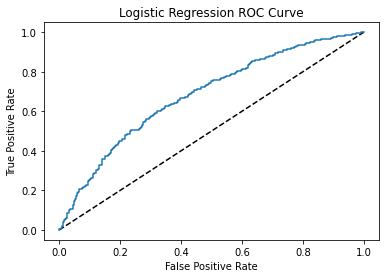

AUC: 0.681


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

scores = log_model.decision_function(X_test)

fpr1, tpr1, _1= roc_curve(Y_test, scores, pos_label=True)

plt.title('Logistic Regression ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1)
plt.show()
auc = roc_auc_score(Y_test, scores)
print('AUC: %.3f' % auc)

## 4.2.3 Acuracy score
This just tells us the percentage of correct predictions that our model made.

In [ ]:
from sklearn.metrics import accuracy_score
print('The Logistic regression accuracy on the test set is {} %'.format(round(accuracy_score(log_predictions,Y_test),3)*100))

The Logistic regression accuracy on the test set is 62.7 %


### 4.2.4 Confusion Matrix
This should give us more information on how its predictions did versus the real results.

In [ ]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(Y_test, log_predictions).ravel()

print("Logistic Regresion Model")
print(f'True Positive: {tp}\nTrue Negative: {tn}\nFalse Positive: {fp}\nFalse Negative: {fn}')

Logistic Regresion Model
True Positive: 327
True Negative: 212
False Positive: 198
False Negative: 122


One conclusion we can make from the confusion matrix is that our model is predicting more t1_results as 1 more than it is predicting 0s.

### 4.2.5 Feature Importance
This should give us a deeper insight into which features our models is taking most into account when doing predictions.


     |████████████████████████████████| 356 kB 793 kB/s 
     |████████████████████████████████| 3.4 MB 18.5 MB/s 
     |████████████████████████████████| 25.3 MB 56.0 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=416300 sha256=acb49874f47d890401770f08d600e75a155558ae5ff74d677666637fc82492ae
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


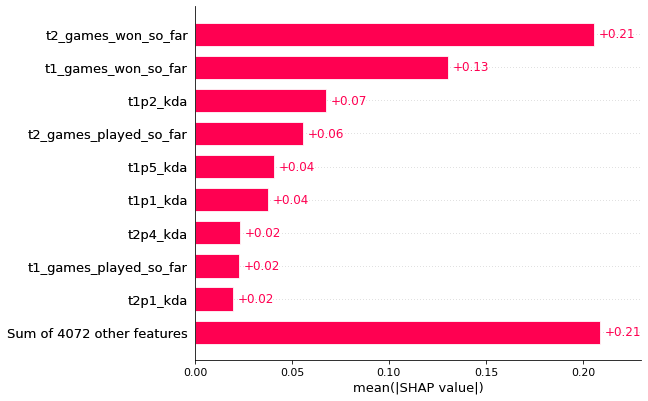

In [ ]:
!pip install shap
import shap
explainer = shap.Explainer(log_model.best_estimator_, X_train)
shap_values_1 = explainer(X_train)
shap.plots.bar(shap_values_1)

Looking at the results we see that the logistic regression model put the amount of games for the team as one of the most important features. This might be because the more games played or won, the more data to work with for a team. It's also important to note that we tried standard scaling those features but it ended up reducing the accuracy of our model.

## 4.3 Random Forest Model <a name="random-forest-model"></a>

In [ ]:
random_forest_model = utils.buildRandomForestModel(X_train,Y_train,feature_names)
random_forest_predictions = random_forest_model.predict(X_test)
print(random_forest_model.best_estimator_)

RandomForestClassifier(max_depth=10)


## 4.3.1 Random Forest Performance Evaluation <a name="random-forest-performance"></a>

### 4.3.2 ROC Curve

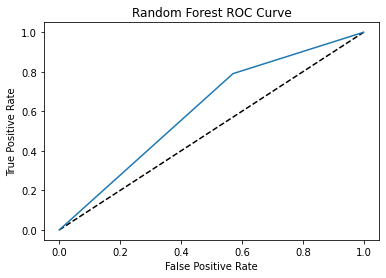

AUC: 0.610


In [ ]:
fpr2, tpr2, _2= roc_curve(Y_test, random_forest_predictions, pos_label=True)

plt.title('Random Forest ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr2, tpr2)
plt.show()
auc = roc_auc_score(Y_test, random_forest_predictions)
print('AUC: %.3f' % auc)

### 4.3.3 Confusion Matrix

In [ ]:
tn, fp, fn, tp = confusion_matrix(Y_test, random_forest_predictions).ravel()

print("Random Forest Model")
print(f'True Positive: {tp}\nTrue Negative: {tn}\nFalse Positive: {fp}\nFalse Negative: {fn}')

Random Forest Model
True Positive: 355
True Negative: 176
False Positive: 234
False Negative: 94


### 4.3.4 Acccuracy score

In [ ]:
print('The Random Forest accuracy on the test set is {} %'.format(round(accuracy_score(random_forest_predictions,Y_test),3)*100))

The Random Forest accuracy on the test set is 61.8 %


### 4.3.5 Feature Importance

<AxesSubplot:>

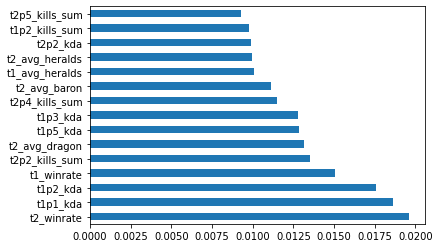

In [ ]:
feat_importances = pd.Series(random_forest_model.best_estimator_.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

Here we see how the win rate had the biggest effect on our Random Forest model.

## 4.4 Neural Network Model <a name="neural-model"></a>

In [ ]:
neural_model = utils.buildNeuralModel(X_train,Y_train,feature_names)

Epoch 1/50
81/81 [==============================] - 1s 3ms/step - loss: 0.6867 - accuracy: 0.5556
Epoch 2/50
81/81 [==============================] - 0s 2ms/step - loss: 0.6160 - accuracy: 0.7060
Epoch 3/50
81/81 [==============================] - 0s 2ms/step - loss: 0.5396 - accuracy: 0.7522
Epoch 4/50
81/81 [==============================] - 0s 2ms/step - loss: 0.4353 - accuracy: 0.8196
Epoch 5/50
81/81 [==============================] - 0s 3ms/step - loss: 0.3332 - accuracy: 0.8694
Epoch 6/50
81/81 [==============================] - 0s 2ms/step - loss: 0.2594 - accuracy: 0.9026
Epoch 7/50
81/81 [==============================] - 0s 2ms/step - loss: 0.1791 - accuracy: 0.9481
Epoch 8/50
81/81 [==============================] - 0s 2ms/step - loss: 0.1095 - accuracy: 0.9781
Epoch 9/50
81/81 [==============================] - 0s 2ms/step - loss: 0.0755 - accuracy: 0.9825
Epoch 10/50
81/81 [==============================] - 0s 2ms/step - loss: 0.0556 - accuracy: 0.9862
Epoch 11/50
81/81 [

## Neural Network Performance Evaluation <a name="neural-model-performance"></a>

### 4.4.1 ROC Curve


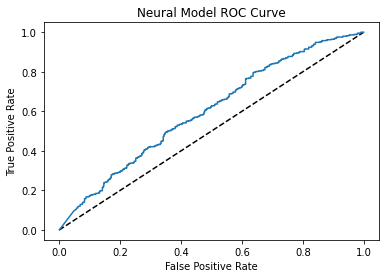

AUC: 0.599


In [ ]:
neural_scores = neural_model.predict(X_test).ravel()

fpr3, tpr3, _3 = roc_curve(Y_test, neural_scores, pos_label=True)

plt.title('Neural Model ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr3, tpr3)
plt.show()
auc = roc_auc_score(Y_test, neural_scores)
print('AUC: %.3f' % auc)

### 4.4.2 Confusion Matrix
This should let us know the correctness our model's predictions.

In [ ]:
predictions = neural_model.predict(X_test).ravel()
predictions = [round(x) for x in predictions]

tn, fp, fn, tp = confusion_matrix(Y_test, predictions).ravel()

print("Neural Model")
print(f'True Positive: {tp}\nTrue Negative: {tn}\nFalse Positive: {fp}\nFalse Negative: {fn}')

Neural Model
True Positive: 261
True Negative: 218
False Positive: 192
False Negative: 188


### 4.4.3 Accuracy Score

In [ ]:
from sklearn.metrics import accuracy_score
print('The Neural Network accuracy on the test set is {} %'.format(round(accuracy_score(predictions,Y_test),3)*100))

The Neural Network accuracy on the test set is 55.800000000000004 %


# Results <a href="results"></a>

Our logistic regression model performed the best in terms of prediction accuracy, and had a prediction accuracy of about 63% accurate to the test set. Our Random forest performed almost as well, with about 62% accuracy in predictions, and our Neural Network model performed slightly worse, having a prediction accuracy of about 55%. This is likely due to our features being composed of continuous linear data, which is a favorable data format when building a logistic regression model.

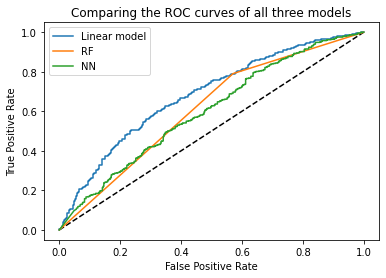

In [ ]:
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Linear model")
plt.plot(fpr2, tpr2, label= "RF")
plt.plot(fpr3, tpr3, label= "NN")
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Comparing the ROC curves of all three models')
plt.show()

# Impact <a href="impact"></a>

Working with something familiar to us as fans of League of Legends and other esports franchises made it easy to stay interested in developing it further. Developing something that is productive in the real world that is also closely related to our hobbies and interests with other team members who have similar interests made this project exciting to work with. This project achieves the goal of taking historical League of Legends match data for various teams to predict the outcome of future matchups. This allows coaches and players to identify top teams and develop strategies or training regiments to replicate their performance with their own teams. This also allows viewers and betters to gain a more informed insight on a future matchup between two teams or perhaps an unscheduled matchup such as between two international teams. One of the limitations we found in working on this project was the amount of match data. While our supply of features was almost too abundant, the amount of games played per team may be too scarce. Each team only played around 40 games throughout the dataset, and using datasets for League of Legends across multiple years presents some issues. The first issue is that data across multiple years for League of Legends would not be fundamentally stable enough to use for a forecasting problem. This is due to the fact that League of Legends drastically changes in objectives and strategies on a yearly basis due to major annual updates by the developers. Another issue is that esports teams similarly rarely ever stay the same yearly as most teams will change in roster and name after the annual world championship tournament. If we were to take this model a bit further, we may be able to develop live predictions such as on a mid match minute by minute basis. We also could have developed the model to predict on a "best of 3" style format rather than a single game which may have increased the accuracy of our predictions.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=95324db2-0e74-4ca0-8b91-3248382bbbb1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>